<a href="https://colab.research.google.com/github/nsandlin1/EEG_Mining/blob/main/EEG_Mining_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link to data files: https://bbci.de/competition/iii/#data_set_v

# Setting up data files

### Refactor from ascii (.asc) to csv (.csv)

```
perl -i -pe 's/(?<=\d)   (?=\d)/,/g' train*
perl -i -pe 's/^   //g' train*

perl -i -pe 's/(?<=\d)  (?=\d)/,/g' test*
perl -i -pe 's/^  //g' test*

for FILENAME in *.asc; do mv "$FILENAME" "${FILENAME%.asc}"; done
for FILENAME in *; do mv "$FILENAME" "${FILENAME}.csv"; done
```

### Import files

In [5]:
# import files to pd dataframe
import pandas as pd
train_subject1_psd01 = pd.read_csv('train_subject1_psd01.csv', header=None)
# train_subject1_psd02 = pd.read_csv('train_subject1_psd01.csv', header=None)
# train_subject1_psd03 = pd.read_csv('train_subject1_psd01.csv', header=None)
# train_subject1 = train_subject1_psd01.append(train_subject1_psd02).append(train_subject1_psd03)
# train_subject2_psd01 = pd.read_csv('train_subject2_psd01.csv', header=None)
# train_subject2_psd02 = pd.read_csv('train_subject2_psd02.csv', header=None)
# train_subject2_psd03 = pd.read_csv('train_subject2_psd03.csv', header=None)
# train_subject3_psd01 = pd.read_csv('train_subject3_psd01.csv', header=None)
# train_subject3_psd02 = pd.read_csv('train_subject3_psd02.csv', header=None)
# train_subject3_psd03 = pd.read_csv('train_subject3_psd03.csv', header=None)

# Data Visualization

<Axes: >

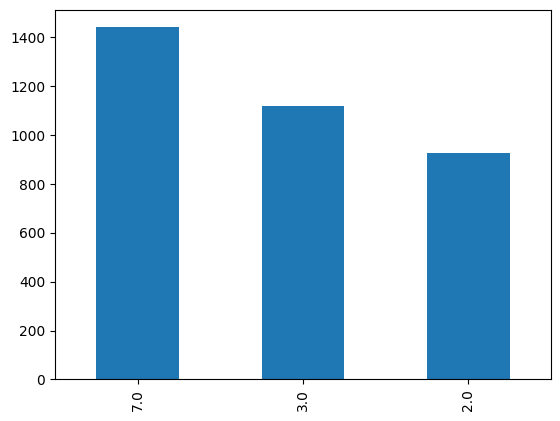

In [ ]:
# view occurance of different actions
# actions are specified by column 97
train_subject1_psd01[96].value_counts().plot(kind='bar')

<Axes: xlabel='0'>

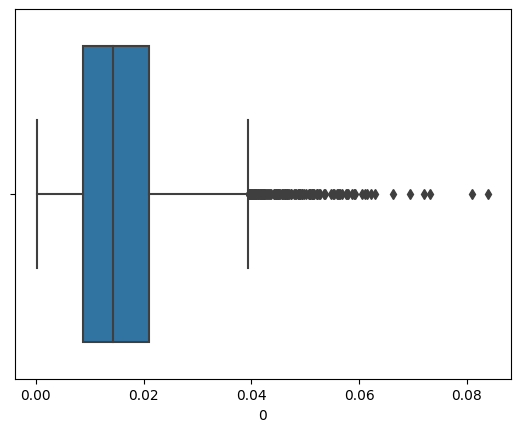

In [ ]:
import seaborn as sns
sns.boxplot(data=train_subject1_psd01, x=0)

# Preprocessing

In [26]:
# function for checking nulls in df
def check_for_nulls(df, verbose=False):
  nulls = df.isnull().sum()

  if verbose:
    zeros = {}
    for key,value in nulls.items():
        zeros[key] = value
    return zeros
  else:
    return nulls

In [27]:
check_for_nulls(train_subject1_psd01)

0     0
1     0
2     0
3     0
4     0
     ..
92    0
93    0
94    0
95    0
96    0
Length: 97, dtype: int64

### Analysis of Multicolinearity

In [22]:
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

from statsmodels.stats.outliers_influence import variance_inflation_factor

# dataframe for independent variables
independents = train_subject1_psd01[[i for i in range(0, 96)]]

# VIF dataframe
vifs = pd.DataFrame()
vifs["attribute"] = independents.columns

# calculate VIF for each attribute
vifs["VIF"] = [variance_inflation_factor(independents.values, i) for i in range(len(independents.columns))]

print(vifs[vifs.VIF < 6])
print(vifs[vifs.VIF > 15])

    attribute       VIF
0           0  5.502826
11         11  5.828397
23         23  5.756342
35         35  5.946383
95         95  5.186868
    attribute        VIF
25         25  20.390979


# Random Forest

In [33]:
# https://www.datacamp.com/tutorial/random-forests-classifier-python

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# define independent and dependent variable subsets
independents = train_subject1_psd01.drop(96, axis=1)
dependents = train_subject1_psd01[96]

##################################################
# Data already has train/test sets partitioned!!!
##################################################

# fit the random forest model
rf = RandomForestClassifier()
rf.fit(independents, dependents)

RandomForestClassifier()